# MasterCard Fraud

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import plotly
import plotly.express as px

In [5]:
# read in data
df = pd.read_csv('data/fraudTrain.csv')

In [6]:
df = df.iloc[: , 1:]
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Exploration of data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [8]:
df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

### Correlation

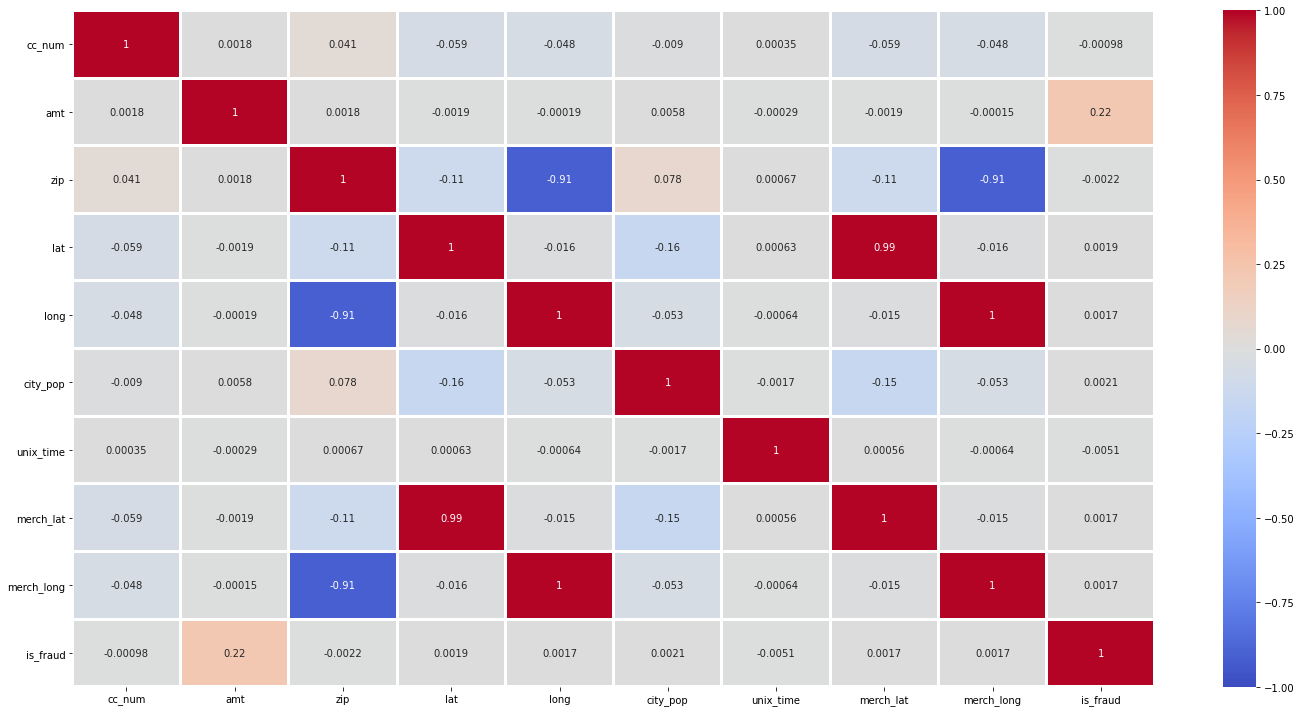

In [9]:
# plot heatmap of all features to view correlation
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1,vmax=1,
           annot=True, linewidths=2)
plt.tight_layout()
plt.show()

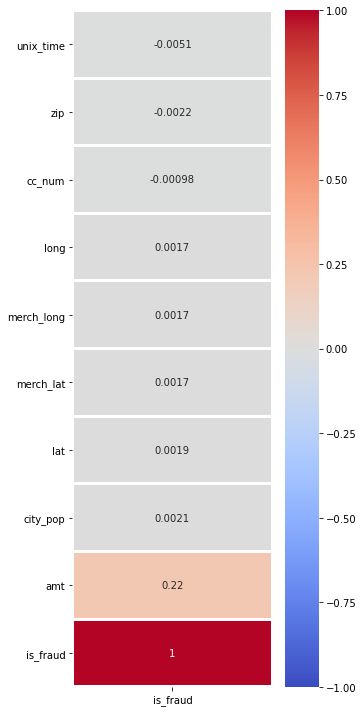

In [10]:
# plot heatmap with just the target variable
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['is_fraud']].sort_values(by=['is_fraud']), cmap='coolwarm', vmin=-1,vmax=1,
           annot=True, linewidths=2)
plt.tight_layout()
plt.show()

In [11]:
# sns.pairplot(df)

### Check Imbalance in Data

In [12]:
x = df['is_fraud'].value_counts()
x

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [13]:
labels = x.index
labels

Int64Index([0, 1], dtype='int64')

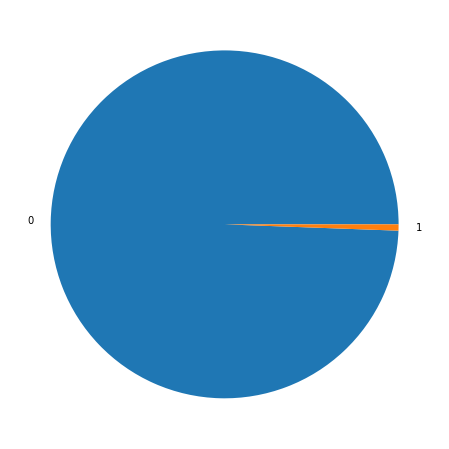

In [14]:
plt.figure(figsize=(8,8))
plt.pie(x, labels = labels)
plt.show()

**Lots of Imbalance!!**

### Upsample data

In [15]:
from sklearn.utils import resample

In [16]:
df_yes= df[df['is_fraud'] ==1]
df_no= df[df['is_fraud'] ==0]

In [17]:
print(df_yes.shape)
print(df_no.shape)

(7506, 22)
(1289169, 22)


In [18]:
df_yes_up = resample(df_yes, replace=True, n_samples = df_no.shape[0], random_state=10)

In [19]:
df_yes_up

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
136228,2019-03-16 03:45:54,6011552879910390,fraud_Friesen-Stamm,gas_transport,7.82,Robert,Long,M,529 Joshua Knoll Apt. 511,Lonetree,...,41.0552,-110.1603,49,Research scientist (physical sciences),1981-07-05,b1b780995b7b597e32e702e5afb9b28d,1331869554,41.528662,-111.115379,1
1263816,2020-06-09 07:12:22,4914700582394237,fraud_Kiehn-Emmerich,grocery_pos,278.64,John,Williams,M,8929 Phillips Corners Suite 259,Harmony,...,40.8496,-80.1381,4589,Bookseller,1956-05-01,ec8ce10166125811bf9529f3d6af25d8,1370761942,40.142351,-80.523525,1
783622,2019-11-30 23:22:29,4800395067176717,fraud_Barrows PLC,shopping_pos,627.87,Daniel,Owens,M,88794 Mandy Lodge Apt. 874,Howells,...,41.6964,-96.9858,1063,Research scientist (maths),1928-04-02,49f4089fedcd0897780872df637bc9cc,1354317749,42.439911,-97.723585,1
146953,2019-03-20 12:57:48,4373370572092720777,"fraud_Dare, Casper and Bartoletti",kids_pets,20.71,Hailey,Rhodes,F,337 Michael Harbors Suite 722,Michigan,...,48.0204,-98.1186,454,"Producer, television/film/video",1972-07-29,17d381aaba915fe6dea346e9889be851,1332248268,49.018526,-98.508584,1
594256,2019-09-09 03:10:27,30499715231997,fraud_Vandervort-Funk,grocery_pos,290.77,Austin,Phillips,M,89871 Woodard Spring Suite 714,Mineral,...,37.9986,-77.8781,9141,Personnel officer,1938-03-15,cb0ed8ab7bb0e540100aba6948dae1d0,1347160227,37.135464,-76.897650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281212,2019-05-19 03:30:56,2720433095629877,"fraud_Stehr, Jewess and Schimmel",misc_net,749.17,Mark,Wood,M,854 Walker Dale Suite 488,Bowdoin,...,44.0575,-69.9656,3224,"Engineer, electronics",1997-08-22,0aab95b83406bbca0e0ad70f9d248efc,1337398256,44.078361,-69.408981,1
297386,2019-05-25 22:22:08,371226440126102,fraud_Padberg-Sauer,home,215.28,Stacy,Lambert,F,85430 Julie Trafficway Suite 792,Mulberry Grove,...,38.9311,-89.2463,1810,Race relations officer,1974-12-24,60c407c871271609caad278d98f39751,1337984528,39.631119,-89.014211,1
1059788,2020-03-16 03:07:39,5289285402893489,fraud_Buckridge PLC,misc_pos,858.02,Amanda,Adams,F,08580 Jeremy Falls,Bay City,...,45.5197,-123.8761,1530,Colour technologist,1986-11-24,955b655d170b110fad4818d2e1033ea3,1363403259,44.739347,-124.300237,1
74186,2019-02-12 23:08:25,6011109736646996,fraud_Crooks and Sons,personal_care,20.98,Rebecca,Erickson,F,594 Berry Lights Apt. 392,Wilmington,...,34.2651,-77.8670,186140,English as a second language teacher,1983-02-08,97aa35feb442e6e1070a75bbbb04aa4b,1329088105,34.768195,-78.709642,1


In [20]:
df = pd.concat([df_no,df_yes_up]).sample(frac=1)

### Feature Encoding

In [21]:
df['merchant']

667341        fraud_Langworth, Boehm and Gulgowski
1088437                            fraud_Kuhic LLC
534416                     fraud_Kuphal-Bartoletti
40637                             fraud_Reilly LLC
239634     fraud_Greenfelder, Bartoletti and Davis
                            ...                   
315300                            fraud_Dooley Inc
494698                       fraud_Vandervort-Funk
614871                        fraud_Corwin-Collins
403886         fraud_Schumm, McLaughlin and Carter
803007                           fraud_Mraz-Herzog
Name: merchant, Length: 2578338, dtype: object

I want to replace get rid of commas and fraud_ fromt the merchant column:

In [22]:
df['merchant'] = df['merchant'].str.replace('fraud_', '').str.replace(',', '').str.replace(' ','_')

In [23]:
df['merchant']

667341        Langworth_Boehm_and_Gulgowski
1088437                           Kuhic_LLC
534416                    Kuphal-Bartoletti
40637                            Reilly_LLC
239634     Greenfelder_Bartoletti_and_Davis
                         ...               
315300                           Dooley_Inc
494698                      Vandervort-Funk
614871                       Corwin-Collins
403886         Schumm_McLaughlin_and_Carter
803007                          Mraz-Herzog
Name: merchant, Length: 2578338, dtype: object

In [24]:
df['merchant'].nunique()

693

In [25]:
df['merchant'].value_counts()

Kilback_LLC                       12451
Cormier_LLC                       11814
Kuhn_LLC                          11092
Rau_and_Sons                      10688
Doyle_Ltd                         10615
                                  ...  
Schroeder_Wolff_and_Hermiston       825
Larson_Quitzon_and_Spencer          821
Hodkiewicz_Prohaska_and_Paucek      787
Ritchie_Bradtke_and_Stiedemann      786
Reichert-Weissnat                   753
Name: merchant, Length: 693, dtype: int64

In [26]:
merchant_values = df['merchant'].value_counts()/len(df)*100
merchant_values

Kilback_LLC                       0.482908
Cormier_LLC                       0.458202
Kuhn_LLC                          0.430200
Rau_and_Sons                      0.414531
Doyle_Ltd                         0.411699
                                    ...   
Schroeder_Wolff_and_Hermiston     0.031997
Larson_Quitzon_and_Spencer        0.031842
Hodkiewicz_Prohaska_and_Paucek    0.030524
Ritchie_Bradtke_and_Stiedemann    0.030485
Reichert-Weissnat                 0.029205
Name: merchant, Length: 693, dtype: float64

In [27]:
threshold_merchant = 0.2

imp_merchant = merchant_values[merchant_values > threshold_merchant]
imp_merchant

Kilback_LLC                 0.482908
Cormier_LLC                 0.458202
Kuhn_LLC                    0.430200
Rau_and_Sons                0.414531
Doyle_Ltd                   0.411699
                              ...   
Weimann_Kuhic_and_Beahan    0.202727
Bernhard_Inc                0.202650
Lesch_Ltd                   0.202495
Heller-Langosh              0.202340
Conroy-Cruickshank          0.200400
Name: merchant, Length: 147, dtype: float64

In [28]:
imp_merchant.nunique()

144

In [29]:
df['merchant'] = np.where(df['merchant'].isin(imp_merchant.index), df['merchant'], 'other')

In [30]:
df['merchant'].nunique()

148

In [31]:
# apply other using lambda
df['merchant'].apply(lambda x: 'other' if x not in imp_merchant.index else x)

667341     Langworth_Boehm_and_Gulgowski
1088437                        Kuhic_LLC
534416                             other
40637                              other
239634                             other
                       ...              
315300                        Dooley_Inc
494698                   Vandervort-Funk
614871                             other
403886                             other
803007                             other
Name: merchant, Length: 2578338, dtype: object

View 'category' column

In [32]:
df['category'].value_counts()

grocery_pos       421862
shopping_net      389569
shopping_pos      260573
gas_transport     237309
misc_net          219961
home              156915
kids_pets         153616
entertainment     133396
personal_care     128258
misc_pos          122525
food_dining       117331
health_fitness    108468
grocery_net        68492
travel             60063
Name: category, dtype: int64

Since there seems to be some additional features in the category column, I think I can extract them and create new features.

I will first create a new_category feature that simplifies the categories and gets rid of 'pos' or 'net' from the category.

In [33]:
df['new_category'] = df['category']

In [34]:
df.loc[df['category'] == 'grocery_pos', 'new_category'] = 'grocery'
df.loc[df['category'] == 'shopping_pos', 'new_category'] = 'shopping'
df.loc[df['category'] == 'shopping_net', 'new_category'] = 'shopping'
df.loc[df['category'] == 'misc_pos', 'new_category'] = 'misc'
df.loc[df['category'] == 'misc_net', 'new_category'] = 'misc'
df.loc[df['category'] == 'grocery_net', 'new_category'] = 'grocery'
df['new_category'].value_counts()

shopping          650142
grocery           490354
misc              342486
gas_transport     237309
home              156915
kids_pets         153616
entertainment     133396
personal_care     128258
food_dining       117331
health_fitness    108468
travel             60063
Name: new_category, dtype: int64

I can create additional features based on categories that are either 'pos' or 'net'

In [35]:
df['category_pos'] = 0

In [36]:
df['category_net'] = 0

In [37]:
df.loc[df['category'] == 'grocery_pos', 'category_pos'] = 1
df.loc[df['category'] == 'misc_pos', 'category_pos'] = 1
df.loc[df['category'] == 'shopping_pos', 'category_pos'] = 1
df['category_pos'].value_counts()

0    1773378
1     804960
Name: category_pos, dtype: int64

In [38]:
df.loc[df['category'] == 'shopping_net', 'category_net'] = 1
df.loc[df['category'] == 'misc_net', 'category_net'] = 1
df.loc[df['category'] == 'grocery_net', 'category_net'] = 1
df['category_pos'].value_counts()

0    1773378
1     804960
Name: category_pos, dtype: int64

#### First & Last Names

In [39]:
df['first'].value_counts()

Christopher    54407
Robert         49378
David          44002
James          39925
Michael        38887
               ...  
Michele          506
Tommy            504
Ricky            503
Peggy            500
Connor           498
Name: first, Length: 352, dtype: int64

In [40]:
first_name_values = df['first'].value_counts()/len(df)*100
first_name_values

Christopher    2.110158
Robert         1.915110
David          1.706603
James          1.548478
Michael        1.508220
                 ...   
Michele        0.019625
Tommy          0.019547
Ricky          0.019509
Peggy          0.019392
Connor         0.019315
Name: first, Length: 352, dtype: float64

In [41]:
threshold_first_name = 0.5

imp_first_name = first_name_values[first_name_values > threshold_first_name]
imp_first_name

Christopher    2.110158
Robert         1.915110
David          1.706603
James          1.548478
Michael        1.508220
Jessica        1.496041
Jennifer       1.468077
William        1.284975
John           1.248285
Mary           1.210198
Amanda         1.151672
Daniel         1.149966
Lisa           1.056029
Joseph         0.983773
Christine      0.940839
Michelle       0.904381
Jeffrey        0.903605
Samuel         0.898757
Jacqueline     0.893444
Kimberly       0.885066
Ashley         0.882351
Margaret       0.833871
Adam           0.826695
Mark           0.825765
Steven         0.814944
Nathan         0.779727
Jeremy         0.766851
Scott          0.763166
Kenneth        0.759288
Melissa        0.757853
Charles        0.752888
Jason          0.725002
Susan          0.715034
Linda          0.695991
Sarah          0.684782
Karen          0.681136
Angela         0.668066
Stephanie      0.664963
Rachel         0.622804
Matthew        0.613923
Ryan           0.588286
Justin         0

In [42]:
imp_first_name.nunique()

46

In [43]:
df['first'] = np.where(df['first'].isin(imp_first_name.index), df['first'], 'other')

In [44]:
df['first'].nunique()

47

In [45]:
# apply other using lambda
df['first'].apply(lambda x: 'other' if x not in imp_first_name.index else x)

667341           other
1088437    Christopher
534416     Christopher
40637            other
239634          Robert
              ...     
315300           other
494698           other
614871         Melissa
403886        Kimberly
803007           other
Name: first, Length: 2578338, dtype: object

In [46]:
df['last'].value_counts()

Smith        52795
Johnson      46721
Davis        44911
Williams     42164
Martinez     37243
             ...  
Alexander      501
Berry          500
Grant          498
Schmidt        491
Bush           485
Name: last, Length: 481, dtype: int64

In [47]:
last_name_values = df['last'].value_counts()/len(df)*100
last_name_values

Smith        2.047637
Johnson      1.812059
Davis        1.741859
Williams     1.635317
Martinez     1.444458
               ...   
Alexander    0.019431
Berry        0.019392
Grant        0.019315
Schmidt      0.019043
Bush         0.018811
Name: last, Length: 481, dtype: float64

In [48]:
threshold_last_name = 0.5

imp_last_name = last_name_values[last_name_values > threshold_last_name]
imp_last_name

Smith        2.047637
Johnson      1.812059
Davis        1.741859
Williams     1.635317
Martinez     1.444458
Jones        1.343268
Rodriguez    1.310301
Thomas       1.046178
Lewis        0.975978
Garcia       0.888673
Gonzalez     0.880490
Miller       0.794233
Allen        0.787523
Clark        0.747769
Brown        0.714918
Martin       0.711039
Hernandez    0.704407
Sanchez      0.685248
Campbell     0.667096
Robinson     0.662132
Mendoza      0.650186
Taylor       0.634091
Bishop       0.633043
Anderson     0.608376
White        0.589760
Foster       0.584369
Bell         0.558887
Sanders      0.533716
Lowe         0.528713
Patterson    0.526308
Perez        0.510406
Gomez        0.502029
Name: last, dtype: float64

In [49]:
imp_last_name.nunique()

32

In [50]:
df['last'] = np.where(df['last'].isin(imp_last_name.index), df['last'], 'other')

In [51]:
df['last'].nunique()

33

In [52]:
# apply other using lambda
df['last'].apply(lambda x: 'other' if x not in imp_last_name.index else x)

667341       other
1088437    Johnson
534416       other
40637        other
239634       other
            ...   
315300       other
494698       other
614871       other
403886       other
803007       other
Name: last, Length: 2578338, dtype: object

In [53]:
df['last'].value_counts()

other        1844531
Smith          52795
Johnson        46721
Davis          44911
Williams       42164
Martinez       37243
Jones          34634
Rodriguez      33784
Thomas         26974
Lewis          25164
Garcia         22913
Gonzalez       22702
Miller         20478
Allen          20305
Clark          19280
Brown          18433
Martin         18333
Hernandez      18162
Sanchez        17668
Campbell       17200
Robinson       17072
Mendoza        16764
Taylor         16349
Bishop         16322
Anderson       15686
White          15206
Foster         15067
Bell           14410
Sanders        13761
Lowe           13632
Patterson      13570
Perez          13160
Gomez          12944
Name: last, dtype: int64

In [54]:
df.drop(['cc_num', 'trans_num', 'street', 'state', 'zip', 'lat', 'long', 
         'unix_time', 'merch_lat', 'merch_long'], 
        axis = 1, inplace = True)

In [55]:
df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'city', 'city_pop', 'job', 'dob', 'is_fraud', 'new_category',
       'category_pos', 'category_net'],
      dtype='object')

In [56]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,gender,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,M,Nelson,732,Television/film/video producer,1956-12-13,1,shopping,0,1
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,M,Greenville,22930,Media planner,1971-11-26,0,shopping,0,1


In [57]:
df["gender"] = np.where(df["gender"]=="M", 1, 0)
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,gender,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,1,Nelson,732,Television/film/video producer,1956-12-13,1,shopping,0,1
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,1,Greenville,22930,Media planner,1971-11-26,0,shopping,0,1


In [58]:
df.rename(columns = {'gender':'is_male'}, inplace=True)

In [59]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,1,Nelson,732,Television/film/video producer,1956-12-13,1,shopping,0,1
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,1,Greenville,22930,Media planner,1971-11-26,0,shopping,0,1


In [60]:
# from datetime import datetime, date
import datetime

In [61]:
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [62]:
dob = datetime.date(1982,8,7)

In [63]:
from_dob_to_age(dob)

38

In [64]:
df['age'] = pd.to_datetime(df.dob)

In [65]:
df['age']

667341    1956-12-13
1088437   1971-11-26
534416    1961-09-28
40637     1968-06-24
239634    1961-01-31
             ...    
315300    1991-01-28
494698    1962-04-30
614871    1980-12-16
403886    1964-11-17
803007    1943-12-17
Name: age, Length: 2578338, dtype: datetime64[ns]

In [66]:
df['age'] = df['age'].apply(lambda x: from_dob_to_age(x))

In [67]:
# year = df['dob'].str.split('-', expand=True)[0].astype('int')
# month = df['dob'].str.split('-', expand=True)[1].astype('int')
# day = df['dob'].str.split('-', expand=True)[2].astype('int')
# born = [year, month, day]

In [68]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net,age
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,1,Nelson,732,Television/film/video producer,1956-12-13,1,shopping,0,1,64
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,1,Greenville,22930,Media planner,1971-11-26,0,shopping,0,1,49


In [69]:
df['city'].value_counts()

Houston        10692
Warren         10261
Utica           9473
San Antonio     9448
Naples          9125
               ...  
Pea Ridge        495
Loving           490
New Franken      490
Dell City        485
West Finley      471
Name: city, Length: 894, dtype: int64

In [70]:
city_values = df['city'].value_counts()/len(df)*100
city_values

Houston        0.414686
Warren         0.397970
Utica          0.367407
San Antonio    0.366438
Naples         0.353910
                 ...   
Pea Ridge      0.019198
Loving         0.019004
New Franken    0.019004
Dell City      0.018811
West Finley    0.018268
Name: city, Length: 894, dtype: float64

In [71]:
threshold_city = 0.2

imp_city = city_values[city_values > threshold_city]
imp_city

Houston          0.414686
Warren           0.397970
Utica            0.367407
San Antonio      0.366438
Naples           0.353910
Huntsville       0.327653
Dallas           0.321098
Detroit          0.311868
Cleveland        0.301745
Topeka           0.300659
Tulsa            0.296392
Brandon          0.295578
Birmingham       0.292592
Conway           0.292243
Arcadia          0.283826
Meridian         0.282934
Allentown        0.280646
Washington       0.280219
Lakeland         0.279948
Burbank          0.278513
Indianapolis     0.273393
Fort Washakie    0.273083
Hudson           0.272579
Thomas           0.269631
New York City    0.253186
Lahoma           0.248610
Fenelton         0.237129
Bowdoin          0.229683
Fulton           0.225261
Walnut Ridge     0.222934
Randolph         0.222391
Beaver Falls     0.222314
Norwalk          0.220801
San Diego        0.220646
Hinesburg        0.218397
Reno             0.217000
Westport         0.215216
Wichita          0.213859
Sebring     

In [72]:
imp_city.nunique()

51

In [73]:
df['city'] = np.where(df['city'].isin(imp_city.index), df['city'], 'other')

In [74]:
df['city'].nunique()

52

In [75]:
# apply other using lambda
df['city'].apply(lambda x: 'other' if x not in imp_city.index else x)

667341        other
1088437       other
534416     Lakeland
40637         other
239634        other
             ...   
315300        other
494698        other
614871        other
403886        other
803007        other
Name: city, Length: 2578338, dtype: object

In [76]:
df['city'].value_counts()

other            2236446
Houston            10692
Warren             10261
Utica               9473
San Antonio         9448
Naples              9125
Huntsville          8448
Dallas              8279
Detroit             8041
Cleveland           7780
Topeka              7752
Tulsa               7642
Brandon             7621
Birmingham          7544
Conway              7535
Arcadia             7318
Meridian            7295
Allentown           7236
Washington          7225
Lakeland            7218
Burbank             7181
Indianapolis        7049
Fort Washakie       7041
Hudson              7028
Thomas              6952
New York City       6528
Lahoma              6410
Fenelton            6114
Bowdoin             5922
Fulton              5808
Walnut Ridge        5748
Randolph            5734
Beaver Falls        5732
Norwalk             5693
San Diego           5689
Hinesburg           5631
Reno                5595
Westport            5549
Wichita             5514
Sebring             5453


In [77]:
df['job'].value_counts()

Materials engineer                18990
Exhibition designer               17932
Naval architect                   17724
Film/video editor                 17338
Surveyor, land/geomatics          17323
                                  ...  
Television camera operator          518
Investment banker, operational      510
Tour manager                        498
Buyer, retail                       496
Hydrogeologist                      485
Name: job, Length: 494, dtype: int64

In [78]:
df['job'] = df['job'].str.replace('/', '_').str.replace(',', '').str.replace(' ','_')

In [79]:
df['job'].value_counts()

Materials_engineer               18990
Exhibition_designer              17932
Naval_architect                  17724
Film_video_editor                17338
Surveyor_land_geomatics          17323
                                 ...  
Television_camera_operator         518
Investment_banker_operational      510
Tour_manager                       498
Buyer_retail                       496
Hydrogeologist                     485
Name: job, Length: 494, dtype: int64

In [80]:
job_values = df['job'].value_counts()/len(df)*100
job_values

Materials_engineer               0.736521
Exhibition_designer              0.695487
Naval_architect                  0.687420
Film_video_editor                0.672449
Surveyor_land_geomatics          0.671867
                                   ...   
Television_camera_operator       0.020090
Investment_banker_operational    0.019780
Tour_manager                     0.019315
Buyer_retail                     0.019237
Hydrogeologist                   0.018811
Name: job, Length: 494, dtype: float64

In [81]:
threshold_job = 0.4

imp_job = job_values[job_values > threshold_job]
imp_job

Materials_engineer                                   0.736521
Exhibition_designer                                  0.695487
Naval_architect                                      0.687420
Film_video_editor                                    0.672449
Surveyor_land_geomatics                              0.671867
Copywriter_advertising                               0.574983
Trading_standards_officer                            0.554466
Mechanical_engineer                                  0.545623
Audiological_scientist                               0.539107
Prison_officer                                       0.536974
Quantity_surveyor                                    0.536586
Podiatrist                                           0.532281
Magazine_features_editor                             0.522973
Scientist_audiological                               0.513432
Financial_trader                                     0.505985
IT_trainer                                           0.492216
Chief_Ex

In [82]:
imp_job.nunique()

44

In [83]:
df['job'] = np.where(df['job'].isin(imp_job.index), df['job'], 'other')

In [84]:
df['job'].nunique()

45

In [85]:
# apply other using lambda
df['job'].apply(lambda x: 'other' if x not in imp_job.index else x)

667341     Television_film_video_producer
1088437                             other
534416                              other
40637                               other
239634                              other
                        ...              
315300                              other
494698                              other
614871                              other
403886                              other
803007                              other
Name: job, Length: 2578338, dtype: object

In [86]:
df['job'].value_counts()

other                                                2024918
Materials_engineer                                     18990
Exhibition_designer                                    17932
Naval_architect                                        17724
Film_video_editor                                      17338
Surveyor_land_geomatics                                17323
Copywriter_advertising                                 14825
Trading_standards_officer                              14296
Mechanical_engineer                                    14068
Audiological_scientist                                 13900
Prison_officer                                         13845
Quantity_surveyor                                      13835
Podiatrist                                             13724
Magazine_features_editor                               13484
Scientist_audiological                                 13238
Financial_trader                                       13046
IT_trainer              

In [87]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net,age
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,1,other,732,Television_film_video_producer,1956-12-13,1,shopping,0,1,64
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,1,other,22930,other,1971-11-26,0,shopping,0,1,49


### Feature Engineering of date & time column

In [88]:
date = df['trans_date_trans_time'].str.split(' ', expand=True)[0]
date

667341     2019-10-11
1088437    2020-03-28
534416     2019-08-17
40637      2019-01-24
239634     2019-04-29
              ...    
315300     2019-06-01
494698     2019-08-03
614871     2019-09-18
403886     2019-07-02
803007     2019-12-05
Name: 0, Length: 2578338, dtype: object

In [89]:
time = df['trans_date_trans_time'].str.split(' ', expand=True)[1]
time

667341     22:30:02
1088437    21:00:33
534416     23:48:08
40637      21:45:50
239634     22:29:01
             ...   
315300     12:33:07
494698     23:45:22
614871     09:57:35
403886     01:34:47
803007     03:36:53
Name: 1, Length: 2578338, dtype: object

In [90]:
df['trans_hour'] = time.str.split(':', expand=True)[0].astype('int')
df['trans_hour']

667341     22
1088437    21
534416     23
40637      21
239634     22
           ..
315300     12
494698     23
614871      9
403886      1
803007      3
Name: trans_hour, Length: 2578338, dtype: int64

In [91]:
df['trans_hour'].value_counts()

22    396954
23    391851
1     155319
0     150945
2     149120
3     147384
18     79819
14     79484
19     79060
15     78955
13     78946
17     78868
16     78733
21     78049
12     76629
20     75671
5      52438
7      51732
8      50900
9      50331
4      49569
11     49320
6      49170
10     49091
Name: trans_hour, dtype: int64

In [92]:
df['trans_is_AM'] = np.where(df['trans_hour'] < 12, 1, 0)
df['trans_is_AM'].value_counts()

0    1573019
1    1005319
Name: trans_is_AM, dtype: int64

In [93]:
df['trans_year'] = date.str.split('-', expand=True)[0].astype('int')
df['trans_year']

667341     2019
1088437    2020
534416     2019
40637      2019
239634     2019
           ... 
315300     2019
494698     2019
614871     2019
403886     2019
803007     2019
Name: trans_year, Length: 2578338, dtype: int64

In [94]:
df['trans_year'].value_counts()

2019    1816957
2020     761381
Name: trans_year, dtype: int64

In [95]:
df['trans_month'] = date.str.split('-', expand=True)[1].astype('int')

In [96]:
df['trans_month'].value_counts()

5     306838
3     304364
6     260882
4     250549
1     249419
2     243251
12    242550
8     152744
10    146858
7     142639
9     141868
11    136376
Name: trans_month, dtype: int64

In [97]:
df['trans_day'] = date.str.split('-', expand=True)[2].astype('int')

In [98]:
df['trans_day'].value_counts()

20    100288
12     97698
11     94238
19     93689
28     93015
8      90747
14     89922
2      89788
17     89556
3      88102
15     86753
7      85533
10     85470
25     85183
29     83774
1      82781
13     82387
22     81493
23     80797
16     80648
21     79861
4      79433
18     79314
30     78167
24     76238
26     76015
9      74903
27     74861
5      72228
6      68546
31     56910
Name: trans_day, dtype: int64

In [99]:
df.head()

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,...,is_fraud,new_category,category_pos,category_net,age,trans_hour,trans_is_AM,trans_year,trans_month,trans_day
667341,2019-10-11 22:30:02,Langworth_Boehm_and_Gulgowski,shopping_net,1041.65,other,other,1,other,732,Television_film_video_producer,...,1,shopping,0,1,64,22,0,2019,10,11
1088437,2020-03-28 21:00:33,Kuhic_LLC,shopping_net,40.48,Christopher,Johnson,1,other,22930,other,...,0,shopping,0,1,49,21,0,2020,3,28
534416,2019-08-17 23:48:08,other,misc_net,880.19,Christopher,other,1,Lakeland,237282,other,...,1,misc,0,1,59,23,0,2019,8,17
40637,2019-01-24 21:45:50,other,home,106.03,other,other,0,other,10256,other,...,0,home,0,0,53,21,0,2019,1,24
239634,2019-04-29 22:29:01,other,misc_net,882.64,Robert,other,1,other,2135,other,...,1,misc,0,1,60,22,0,2019,4,29


In [100]:
df.drop(['trans_date_trans_time', 'dob'], axis = 1, inplace = True)

In [101]:
df.dtypes

merchant         object
category         object
amt             float64
first            object
last             object
is_male           int64
city             object
city_pop          int64
job              object
is_fraud          int64
new_category     object
category_pos      int64
category_net      int64
age               int64
trans_hour        int64
trans_is_AM       int64
trans_year        int64
trans_month       int64
trans_day         int64
dtype: object

### One hot encoding:

In [102]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']

In [103]:
cat_features

['merchant', 'category', 'first', 'last', 'city', 'job', 'new_category']

In [104]:
for feature in cat_features:
    print(f'{feature} has total {df[feature].nunique()} unique features')

merchant has total 148 unique features
category has total 14 unique features
first has total 47 unique features
last has total 33 unique features
city has total 52 unique features
job has total 45 unique features
new_category has total 11 unique features


In [105]:
df[cat_features].head()

,merchant,category,first,last,city,job,new_category
667341,Langworth_Boehm_and_Gulgowski,shopping_net,other,other,other,Television_film_video_producer,shopping
1088437,Kuhic_LLC,shopping_net,Christopher,Johnson,other,other,shopping
534416,other,misc_net,Christopher,other,Lakeland,other,misc
40637,other,home,other,other,other,other,home
239634,other,misc_net,Robert,other,other,other,misc


In [106]:
data_cat = df[cat_features]

In [107]:
for col in cat_features:
    col_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
    data_cat = pd.concat([data_cat, col_encoded], axis = 1)
    data_cat.drop(col, axis = 1, inplace = True)

In [108]:
data_cat.shape

(2578338, 343)

In [109]:
data_cat.head()

,merchant_Ankunding_LLC,merchant_Auer-Mosciski,merchant_Auer-West,merchant_Bahringer_Schoen_and_Corkery,merchant_Bailey-Morar,merchant_Barrows_PLC,merchant_Bartoletti-Wunsch,merchant_Barton_Inc,merchant_Bashirian_Group,merchant_Bauch-Raynor,...,new_category_food_dining,new_category_gas_transport,new_category_grocery,new_category_health_fitness,new_category_home,new_category_kids_pets,new_category_misc,new_category_personal_care,new_category_shopping,new_category_travel
667341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1088437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
534416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
40637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
239634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [110]:
num_features = [col for col in df.columns if df[col].dtype != 'object']

In [111]:
num_features

['amt',
 'is_male',
 'city_pop',
 'is_fraud',
 'category_pos',
 'category_net',
 'age',
 'trans_hour',
 'trans_is_AM',
 'trans_year',
 'trans_month',
 'trans_day']

In [112]:
# concat
df_final = pd.concat([df.loc[:,num_features], data_cat], axis = 1)

In [113]:
df_final.head()

,amt,is_male,city_pop,is_fraud,category_pos,category_net,age,trans_hour,trans_is_AM,trans_year,...,new_category_food_dining,new_category_gas_transport,new_category_grocery,new_category_health_fitness,new_category_home,new_category_kids_pets,new_category_misc,new_category_personal_care,new_category_shopping,new_category_travel
667341,1041.65,1,732,1,0,1,64,22,0,2019,...,0,0,0,0,0,0,0,0,1,0
1088437,40.48,1,22930,0,0,1,49,21,0,2020,...,0,0,0,0,0,0,0,0,1,0
534416,880.19,1,237282,1,0,1,59,23,0,2019,...,0,0,0,0,0,0,1,0,0,0
40637,106.03,0,10256,0,0,0,53,21,0,2019,...,0,0,0,0,1,0,0,0,0,0
239634,882.64,1,2135,1,0,1,60,22,0,2019,...,0,0,0,0,0,0,1,0,0,0


### Assign features to X and y

In [114]:
X = df_final.drop('is_fraud', axis = 1)
y = df_final['is_fraud']

In [115]:
# X = df_upsampled.drop('is_fraud', axis = 1)
# y = df_upsampled['is_fraud']

In [116]:
# split data into new train and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42, stratify = y)

### Models

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [119]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [120]:
s_scaler = StandardScaler()
s_scaler = s_scaler.fit(X_train)
X_train_scaled = s_scaler.transform(X_train)

norm_scaler = MinMaxScaler()
norm_scaler = norm_scaler.fit(X_train)
X_train_norm_scaled = norm_scaler.transform(X_train)

display(X_train_scaled.shape)
display(X_train_norm_scaled.shape)

(2062670, 354)

(2062670, 354)

In [121]:
X_test_scaled = s_scaler.transform(X_test)

X_test_norm_scaled = norm_scaler.transform(X_test)

display(X_test_scaled.shape)
display(X_test_norm_scaled.shape)

(515668, 354)

(515668, 354)

In [122]:
logistic_regression_model_s_scaled = LogisticRegression()

logistic_regression_model_s_scaled.fit(X_train_scaled, y_train)

# Accuracy
print(f"Train accuracy of min/max scaled data: {logistic_regression_model_s_scaled.score(X_train_scaled, y_train)}")
print(f"Test accuracy of min/max scaled data:  {logistic_regression_model_s_scaled.score(X_test_scaled, y_test)}")

Train accuracy of min/max scaled data: 0.834739439658307
Test accuracy of min/max scaled data:  0.8342809714777725


In [123]:
logistic_regression_model_min_max = LogisticRegression()

logistic_regression_model_min_max.fit(X_train_norm_scaled, y_train)

# Accuracy
print(f"Train accuracy of min/max scaled data: {logistic_regression_model_min_max.score(X_train_norm_scaled, y_train)}")
print(f"Test accuracy of min/max scaled data:  {logistic_regression_model_min_max.score(X_test_norm_scaled, y_test)}")

Train accuracy of min/max scaled data: 0.8298617810895587
Test accuracy of min/max scaled data:  0.8293785924276861


In [129]:
test_scores = []
train_scores = []

C_range = np.array([.001,.01,0.1,1,10,100,1000,10000, 100000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(X_train_scaled,y_train)

    train_scores.append(my_logreg.score(X_train_scaled,y_train))

    test_scores.append(my_logreg.score(X_test_scaled,y_test))

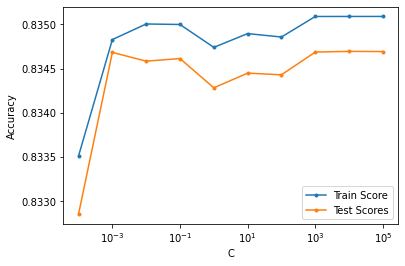

In [130]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, test_scores,label="Test Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [ ]:
nbmodel = BernoulliNB()

nbmodel.fit(X_train_norm_scaled,y_train)

In [ ]:
print(f"Train accuracy of min/max scaled data: {nbmodel.score(X_train_norm_scaled, y_train)}")
print(f"Test accuracy of min/max scaled data:  {nbmodel.score(X_test_norm_scaled, y_test)}")

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
models = []

models.append(('LogisticRegression', LogisticRegression()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('Decision tree', DecisionTreeClassifier()))

# KNN takes very long
# models.append(('KNN', KNeighborsClassifier()))

# Gives warning
# models.append(('XGBoost', XGBClassifier()))

In [ ]:
for name, model in models:
    print(name)
    print(model)

In [ ]:
for name, model in models:
    print(name)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    cm = confusion_matrix(predictions, y_test)
    print(cm)
    
    acc = accuracy_score(predictions, y_test)
    print(acc)
    print('\n')

In [ ]:
estimators = [
    ('scalers', StandardScaler()),
              ('model',SVC())
             ]

pipe = Pipeline(estimators,memory=cachedir)

param_grid=[
    {'model':[SVC()],'scalers':[StandardScaler(),MinMaxScaler()],
             'model__gamma':[0.001,0.1,1,10], 'model__C':[0.01,0.1,1,10]},
            {'model':[DecisionTreeClassifier()],'scalers':
             [None],'model__max_depth':[3,7,12,15]},
    
#             {'model':[KNeighborsClassifier()],'scalers':[StandardScaler(),MinMaxScaler()],
#              'model__n_neighbors':[5,10,15,20]},
            {'model':[RandomForestClassifier()],'scalers':[None,StandardScaler(),MinMaxScaler()],
             'model__n_estimators':[50,100,150,200],'model__max_depth':[3,7,12,15]},
            {'model':[LogisticRegression()],'scalers':[None, StandardScaler(), MinMaxScaler()],
             'model__C':[0.001, 0.01,0.1,1,10],'model__penalty':['l1','l2', 'lbfgs']
            },
    
#             {'model':[XGBClassifier(use_label_encoder=False)],'scalers':[None,StandardScaler(),MinMaxScaler()],
#              'model__max_depth':[3,7,12,15],'model__learning_rate':[0.2,0.4,0.7,1]},
    
            {'model':[GaussianNB()],'scalers':[None,StandardScaler(),MinMaxScaler()]}
]

In [ ]:
grid_model = GridSearchCV(pipe, param_grid = param_grid, verbose= 2, n_jobs = -1)

In [ ]:
grid_model.fit(X_train,y_train)

In [ ]:
grid_model.best_estimator_

In [ ]:
grid_model.best_score_

In [ ]:
grid_model.score(X_test,y_test)